In [13]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt

import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
from SplineEncodingModel.LinearRegressionSpline import EncodingModel, NBDecodingModel
from SplineEncodingModel import PopDecodingCV as pdcv
import matplotlib.gridspec as gridspec
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = pp.load_session_db()


df = df[df['RewardCount']>20]
# df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [15]:
mouse = '4343705.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
# df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
3068,4343705.2,13_01_2020,1,TwoTower_noTimeout,100,0,CA1,2020-01-13,G:\My Drive\VR_Data\TwoTower\4343705.2\13_01_2...,None,None,None
3071,4343705.2,13_01_2020,4,TwoTower_noTimeout,69,1,CA1,2020-01-13,G:\My Drive\VR_Data\TwoTower\4343705.2\13_01_2...,None,None,None
3072,4343705.2,13_01_2020,5,TwoTower_noTimeout,100,0,CA1,2020-01-13,G:\My Drive\VR_Data\TwoTower\4343705.2\13_01_2...,None,None,None
3087,4343705.2,14_01_2020,1,TwoTower_noTimeout,250,0,CA1,2020-01-14,G:\My Drive\VR_Data\TwoTower\4343705.2\14_01_2...,None,None,None
3096,4343705.2,15_01_2020,1,TwoTower_noTimeout,102,0,CA1,2020-01-15,G:\My Drive\VR_Data\TwoTower\4343705.2\15_01_2...,None,None,None
3098,4343705.2,15_01_2020,3,TwoTower_noTimeout,101,1,CA1,2020-01-15,G:\My Drive\VR_Data\TwoTower\4343705.2\15_01_2...,None,None,None
3099,4343705.2,15_01_2020,4,TwoTower_noTimeout,100,0,CA1,2020-01-15,G:\My Drive\VR_Data\TwoTower\4343705.2\15_01_2...,None,None,None
3115,4343705.2,16_01_2020,1,TwoTower_noTimeout,300,0,CA1,2020-01-16,G:\My Drive\VR_Data\TwoTower\4343705.2\16_01_2...,None,None,None


In [16]:
sess = df_mouse.iloc[-1]

C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


(366, 45) (366,)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


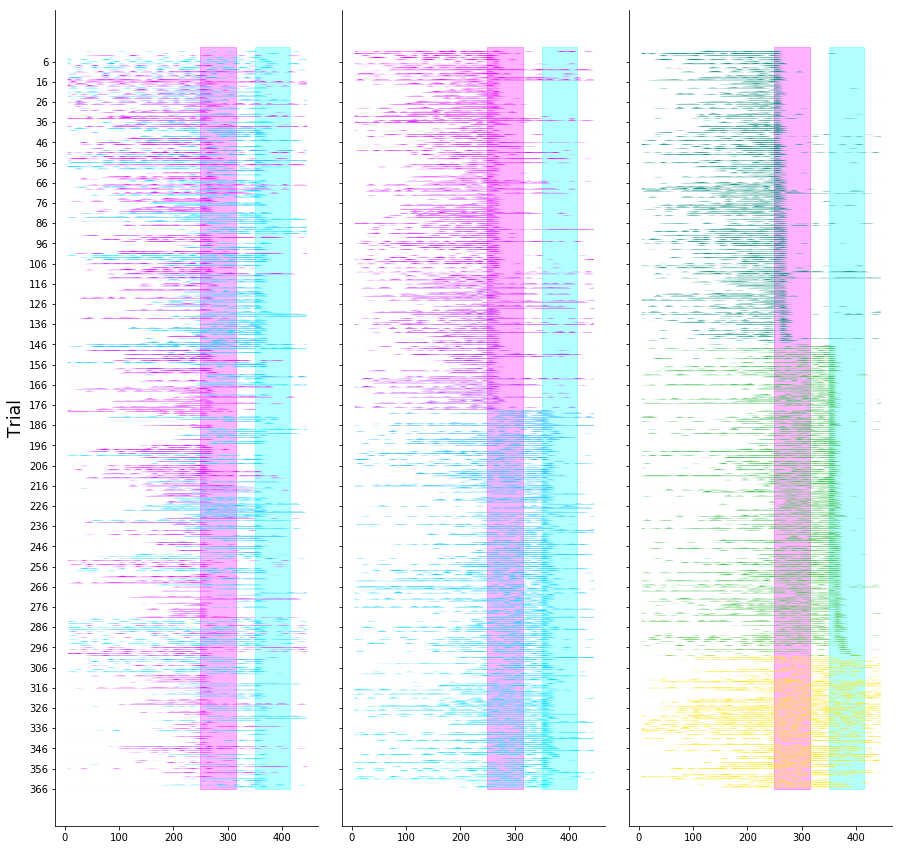

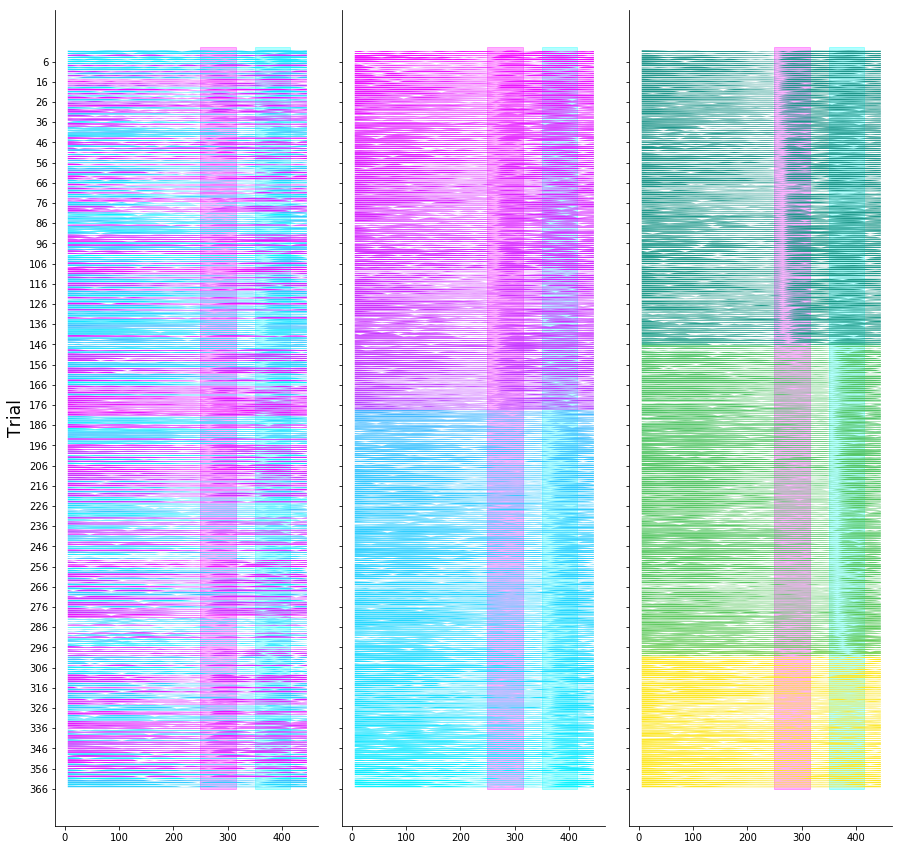

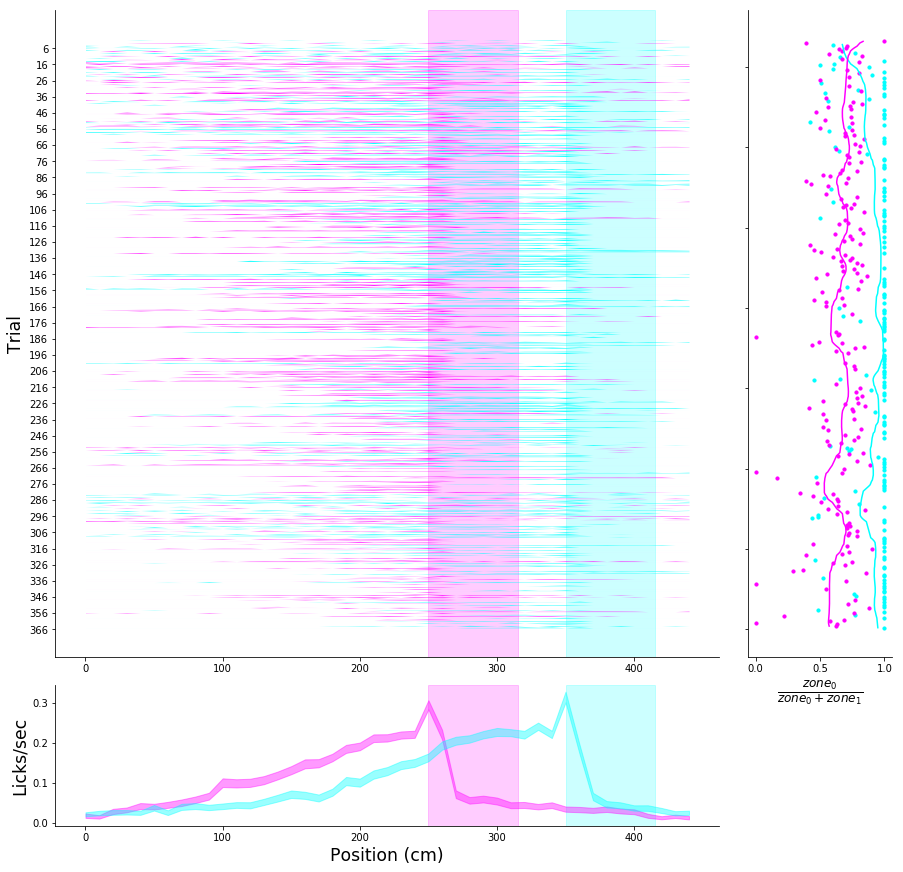

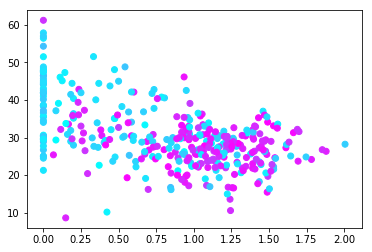

In [17]:
VRDat = pp.behavior_dataframe(sess['data file'])
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
lick_trial_mat,occ,edges,centers= u.make_pos_bin_trial_matrices(VRDat['lick']._values,
                                                            VRDat['pos']._values,
                                                            VRDat['tstart']._values,
                                                            VRDat['teleport']._values,
                                                            bin_size=10)
lick_trial_mat = lick_trial_mat[:,:]
print(lick_trial_mat.shape,trial_info['morphs'].shape)
lick_morph_dict = u.trial_type_dict(lick_trial_mat,trial_info['morphs'])
speed_trial_mat = u.make_pos_bin_trial_matrices(VRDat['speed']._values,
                                                        VRDat['pos']._values,
                                                        VRDat['tstart']._values,
                                                        VRDat['teleport']._values,
                                                        mat_only=True,bin_size=10)

effMorph = (trial_info['morphs']+trial_info['wallJitter']+trial_info['bckgndJitter']+.25)/1.5
reward_pos = trial_info['reward_pos']
reward_pos[np.isnan(reward_pos)]= 480.
# f_lick, axarr_lick = b.behavior_raster_foraging(lick_trial_mat/np.nanmax(lick_trial_mat.ravel()),
#                                                 centers,effMorph,reward_pos/480.,smooth=False)
f_lick, axarr_lick = b.behavior_raster_task(lick_trial_mat/np.nanmax(lick_trial_mat.ravel()),
                                                centers,effMorph,reward_pos/480.,smooth=False,TO=False)
f_speed,axarr_speed = b.behavior_raster_task(speed_trial_mat/np.nanmax(speed_trial_mat.ravel()),
                                                  centers,effMorph,reward_pos/480.,smooth=False,TO=False)

f_lick_o, (ax_lick, meanlr_ax, lickrat_ax) = b.lick_plot_task(lick_morph_dict,edges,smooth=False)


f_sl, ax_spl = b.ant_speed_v_lick(lick_trial_mat,speed_trial_mat,centers,effMorph)

In [12]:
print(lick_morph_dict.keys())

dict_keys(['all', 'labels', 'indices', 0.0, 1.0])


In [43]:
print(effMorph.shape)

(75,)


In [30]:
# f_lick.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\4222157.4_sess13_licks.pdf",format='pdf')

In [38]:
a = np.arange(20)
print(a[::2])

[ 0  2  4  6  8 10 12 14 16 18]
